In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap


import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/malimg_paper_dataset_imgs"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
X.shape

(9339, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [7]:
# Training the model from scratch
num_epochs=2000
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
checkpointer = ModelCheckpoint(filepath='weights-malimg-resnet50-avgpool-Adam-2000epochs-fromscratch.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
for i in range(1):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    base_model = ResNet50(weights=None, input_shape=image_shape, include_top=False)
    
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D(name='global_avg_pool'))
    model.add(Dense(num_classes, activation='softmax', name='predictions'))
    
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 8394 samples, validate on 945 samples
Epoch 1/2000
8394/8394 [==============================] - 103s - loss: 0.8213 - acc: 0.8100 - val_loss: 11.5055 - val_acc: 0.0487
Epoch 2/2000
8394/8394 [==============================] - 87s - loss: 0.2368 - acc: 0.9344 - val_loss: 11.1222 - val_acc: 0.2751
Epoch 3/2000
8394/8394 [==============================] - 86s - loss: 0.1614 - acc: 0.9539 - val_loss: 0.7262 - val_acc: 0.7831
Epoch 4/2000
8394/8394 [==============================] - 86s - loss: 0.1692 - acc: 0.9529 - val_loss: 6.5680 - val_acc: 0.5746
Epoch 5/2000
8394/8394 [==============================] - 86s - loss: 0.1788 - acc: 0.9601 - val_loss: 10.9332 - val_acc: 0.2942
Epoch 6/2000
8394/8394 [==============================] - 84s - loss: 0.2833 - acc: 0.9371 - val_loss: 0.4599 - val_acc: 0.8423
Epoch 7/2000
8394/8394 [==============================] - 94s - loss: 0.1288 - acc: 0.9638 - val_loss: 0.1991 - val_acc: 0.9429
Epoch 8/2000
8394/8394 [=============================

8394/8394 [==============================] - 85s - loss: 0.3523 - acc: 0.9612 - val_loss: 3.1695 - val_acc: 0.6286
Epoch 64/2000
8394/8394 [==============================] - 85s - loss: 0.0964 - acc: 0.9861 - val_loss: 0.0865 - val_acc: 0.9820
Epoch 65/2000
8394/8394 [==============================] - 85s - loss: 0.0096 - acc: 0.9964 - val_loss: 0.0586 - val_acc: 0.9852
Epoch 66/2000
8394/8394 [==============================] - 84s - loss: 0.0172 - acc: 0.9948 - val_loss: 0.0625 - val_acc: 0.9852
Epoch 67/2000
8394/8394 [==============================] - 85s - loss: 0.0121 - acc: 0.9959 - val_loss: 0.0575 - val_acc: 0.9862
Epoch 68/2000
8394/8394 [==============================] - 85s - loss: 0.0041 - acc: 0.9987 - val_loss: 0.0852 - val_acc: 0.9852
Epoch 69/2000
8394/8394 [==============================] - 85s - loss: 0.0445 - acc: 0.9884 - val_loss: 0.0847 - val_acc: 0.9841
Epoch 70/2000
8394/8394 [==============================] - 85s - loss: 0.0109 - acc: 0.9969 - val_loss: 0.1115 

8394/8394 [==============================] - 85s - loss: 0.0018 - acc: 0.9994 - val_loss: 0.0690 - val_acc: 0.9884
Epoch 127/2000
8394/8394 [==============================] - 85s - loss: 3.3191e-04 - acc: 1.0000 - val_loss: 0.0548 - val_acc: 0.9894
Epoch 128/2000
8394/8394 [==============================] - 84s - loss: 9.8650e-05 - acc: 1.0000 - val_loss: 0.0511 - val_acc: 0.9926
Epoch 129/2000
8394/8394 [==============================] - 85s - loss: 8.2747e-05 - acc: 1.0000 - val_loss: 0.0497 - val_acc: 0.9926
Epoch 130/2000
8394/8394 [==============================] - 85s - loss: 2.5987e-04 - acc: 0.9999 - val_loss: 0.0535 - val_acc: 0.9894
Epoch 131/2000
8394/8394 [==============================] - 84s - loss: 0.0183 - acc: 0.9956 - val_loss: 0.0730 - val_acc: 0.9841
Epoch 132/2000
8394/8394 [==============================] - 84s - loss: 6.2560e-04 - acc: 0.9999 - val_loss: 0.0620 - val_acc: 0.9894
Epoch 133/2000
8394/8394 [==============================] - 84s - loss: 0.0034 - acc:

8394/8394 [==============================] - 84s - loss: 8.3278e-05 - acc: 1.0000 - val_loss: 0.0514 - val_acc: 0.9915
Epoch 188/2000
8394/8394 [==============================] - 84s - loss: 1.2436e-04 - acc: 1.0000 - val_loss: 0.0503 - val_acc: 0.9915
Epoch 189/2000
8394/8394 [==============================] - 84s - loss: 3.9668e-05 - acc: 1.0000 - val_loss: 0.0520 - val_acc: 0.9926
Epoch 190/2000
8394/8394 [==============================] - 85s - loss: 4.7714e-05 - acc: 1.0000 - val_loss: 0.0542 - val_acc: 0.9915
Epoch 191/2000
8394/8394 [==============================] - 84s - loss: 0.0019 - acc: 0.9990 - val_loss: 0.1251 - val_acc: 0.9862
Epoch 192/2000
8394/8394 [==============================] - 84s - loss: 0.0024 - acc: 0.9994 - val_loss: 0.0611 - val_acc: 0.9894
Epoch 193/2000
8394/8394 [==============================] - 84s - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0689 - val_acc: 0.9905
Epoch 194/2000
8394/8394 [==============================] - 84s - loss: 6.1148e-04 - acc:

8394/8394 [==============================] - 85s - loss: 1.0910e-04 - acc: 1.0000 - val_loss: 0.0620 - val_acc: 0.9915
Epoch 249/2000
8394/8394 [==============================] - 84s - loss: 4.3260e-04 - acc: 0.9998 - val_loss: 0.0572 - val_acc: 0.9894
Epoch 250/2000
8394/8394 [==============================] - 85s - loss: 0.0116 - acc: 0.9963 - val_loss: 0.0776 - val_acc: 0.9884
Epoch 251/2000
8394/8394 [==============================] - 85s - loss: 7.1284e-04 - acc: 0.9998 - val_loss: 0.0665 - val_acc: 0.9915
Epoch 252/2000
8394/8394 [==============================] - 85s - loss: 0.0043 - acc: 0.9988 - val_loss: 0.0735 - val_acc: 0.9884
Epoch 253/2000
8394/8394 [==============================] - 84s - loss: 2.4616e-04 - acc: 1.0000 - val_loss: 0.0633 - val_acc: 0.9905
Epoch 254/2000
8394/8394 [==============================] - 85s - loss: 6.0611e-04 - acc: 0.9996 - val_loss: 0.1170 - val_acc: 0.9841
Epoch 255/2000
8394/8394 [==============================] - 85s - loss: 0.0027 - acc:

8394/8394 [==============================] - 89s - loss: 2.2560e-05 - acc: 1.0000 - val_loss: 0.0771 - val_acc: 0.9884
Epoch 310/2000
8394/8394 [==============================] - 95s - loss: 1.7553e-05 - acc: 1.0000 - val_loss: 0.0791 - val_acc: 0.9894
Epoch 311/2000
8394/8394 [==============================] - 99s - loss: 1.4171e-05 - acc: 1.0000 - val_loss: 0.0787 - val_acc: 0.9905
Epoch 312/2000
8394/8394 [==============================] - 93s - loss: 1.2065e-05 - acc: 1.0000 - val_loss: 0.0789 - val_acc: 0.9905
Epoch 313/2000
8394/8394 [==============================] - 96s - loss: 5.0681e-05 - acc: 1.0000 - val_loss: 0.0764 - val_acc: 0.9894
Epoch 314/2000
8394/8394 [==============================] - 90s - loss: 1.2367e-05 - acc: 1.0000 - val_loss: 0.0770 - val_acc: 0.9894
Epoch 315/2000
8394/8394 [==============================] - 93s - loss: 8.6026e-06 - acc: 1.0000 - val_loss: 0.0764 - val_acc: 0.9905
Epoch 316/2000
8394/8394 [==============================] - 92s - loss: 2.726

8394/8394 [==============================] - 102s - loss: 4.9318e-04 - acc: 0.9999 - val_loss: 0.0642 - val_acc: 0.9915
Epoch 371/2000
8394/8394 [==============================] - 100s - loss: 2.9374e-05 - acc: 1.0000 - val_loss: 0.0680 - val_acc: 0.9915
Epoch 372/2000
8394/8394 [==============================] - 101s - loss: 6.9060e-06 - acc: 1.0000 - val_loss: 0.0681 - val_acc: 0.9915
Epoch 373/2000
8394/8394 [==============================] - 96s - loss: 7.6572e-06 - acc: 1.0000 - val_loss: 0.0681 - val_acc: 0.9915
Epoch 374/2000
8394/8394 [==============================] - 99s - loss: 2.1785e-04 - acc: 0.9999 - val_loss: 0.0717 - val_acc: 0.9915
Epoch 375/2000
8394/8394 [==============================] - 96s - loss: 0.0059 - acc: 0.9982 - val_loss: 0.1063 - val_acc: 0.9841
Epoch 376/2000
8394/8394 [==============================] - 103s - loss: 8.0467e-04 - acc: 0.9996 - val_loss: 0.0856 - val_acc: 0.9915
Epoch 377/2000
8394/8394 [==============================] - 98s - loss: 7.836

8394/8394 [==============================] - 84s - loss: 5.3275e-04 - acc: 0.9998 - val_loss: 0.0954 - val_acc: 0.9884
Epoch 432/2000
8394/8394 [==============================] - 84s - loss: 1.1912e-05 - acc: 1.0000 - val_loss: 0.0829 - val_acc: 0.9905
Epoch 433/2000
8394/8394 [==============================] - 84s - loss: 2.1044e-05 - acc: 1.0000 - val_loss: 0.0801 - val_acc: 0.9905
Epoch 434/2000
8394/8394 [==============================] - 84s - loss: 4.9503e-04 - acc: 0.9999 - val_loss: 0.0946 - val_acc: 0.9905
Epoch 435/2000
8394/8394 [==============================] - 84s - loss: 0.0055 - acc: 0.9988 - val_loss: 0.1103 - val_acc: 0.9894
Epoch 436/2000
8394/8394 [==============================] - 84s - loss: 0.0034 - acc: 0.9995 - val_loss: 0.0981 - val_acc: 0.9873
Epoch 437/2000
8394/8394 [==============================] - 84s - loss: 0.0015 - acc: 0.9998 - val_loss: 0.0767 - val_acc: 0.9915
Epoch 438/2000
8394/8394 [==============================] - 84s - loss: 5.7211e-05 - acc:

8394/8394 [==============================] - 84s - loss: 2.9232e-06 - acc: 1.0000 - val_loss: 0.0665 - val_acc: 0.9905
Epoch 493/2000
8394/8394 [==============================] - 84s - loss: 7.0965e-04 - acc: 0.9999 - val_loss: 0.0738 - val_acc: 0.9915
Epoch 494/2000
8394/8394 [==============================] - 84s - loss: 0.0090 - acc: 0.9982 - val_loss: 0.0841 - val_acc: 0.9841
Epoch 495/2000
8394/8394 [==============================] - 84s - loss: 1.2422e-04 - acc: 1.0000 - val_loss: 0.0757 - val_acc: 0.9937
Epoch 496/2000
8394/8394 [==============================] - 84s - loss: 8.7100e-04 - acc: 0.9996 - val_loss: 0.0902 - val_acc: 0.9915
Epoch 497/2000
8394/8394 [==============================] - 84s - loss: 6.4402e-05 - acc: 1.0000 - val_loss: 0.0885 - val_acc: 0.9926
Epoch 498/2000
8394/8394 [==============================] - 84s - loss: 5.5021e-05 - acc: 1.0000 - val_loss: 0.0870 - val_acc: 0.9926
Epoch 499/2000
8394/8394 [==============================] - 84s - loss: 4.3408e-0

8394/8394 [==============================] - 89s - loss: 2.9453e-06 - acc: 1.0000 - val_loss: 0.0928 - val_acc: 0.9905
Epoch 554/2000
8394/8394 [==============================] - 89s - loss: 2.3598e-06 - acc: 1.0000 - val_loss: 0.0928 - val_acc: 0.9905
Epoch 555/2000
8394/8394 [==============================] - 89s - loss: 6.4207e-06 - acc: 1.0000 - val_loss: 0.0929 - val_acc: 0.9905
Epoch 556/2000
8394/8394 [==============================] - 89s - loss: 4.6366e-06 - acc: 1.0000 - val_loss: 0.0939 - val_acc: 0.9905
Epoch 557/2000
8394/8394 [==============================] - 89s - loss: 1.8465e-06 - acc: 1.0000 - val_loss: 0.0941 - val_acc: 0.9905
Epoch 558/2000
8394/8394 [==============================] - 89s - loss: 2.9419e-06 - acc: 1.0000 - val_loss: 0.0938 - val_acc: 0.9905
Epoch 559/2000
8394/8394 [==============================] - 88s - loss: 3.2706e-05 - acc: 1.0000 - val_loss: 0.0977 - val_acc: 0.9905
Epoch 560/2000
8394/8394 [==============================] - 89s - loss: 0.002

8394/8394 [==============================] - 85s - loss: 4.6227e-05 - acc: 1.0000 - val_loss: 0.0803 - val_acc: 0.9926
Epoch 615/2000
8394/8394 [==============================] - 85s - loss: 8.3406e-06 - acc: 1.0000 - val_loss: 0.0767 - val_acc: 0.9915
Epoch 616/2000
8394/8394 [==============================] - 86s - loss: 1.9000e-06 - acc: 1.0000 - val_loss: 0.0762 - val_acc: 0.9915
Epoch 617/2000
8394/8394 [==============================] - 87s - loss: 2.3951e-06 - acc: 1.0000 - val_loss: 0.0761 - val_acc: 0.9915
Epoch 618/2000
8394/8394 [==============================] - 88s - loss: 1.2609e-06 - acc: 1.0000 - val_loss: 0.0760 - val_acc: 0.9915
Epoch 619/2000
8394/8394 [==============================] - 88s - loss: 3.3392e-06 - acc: 1.0000 - val_loss: 0.0761 - val_acc: 0.9926
Epoch 620/2000
8394/8394 [==============================] - 88s - loss: 4.6860e-06 - acc: 1.0000 - val_loss: 0.0759 - val_acc: 0.9926
Epoch 621/2000
8394/8394 [==============================] - 87s - loss: 1.645

8394/8394 [==============================] - 85s - loss: 0.0014 - acc: 0.9998 - val_loss: 0.4465 - val_acc: 0.9058
Epoch 676/2000
8394/8394 [==============================] - 85s - loss: 1.7381e-04 - acc: 1.0000 - val_loss: 0.0705 - val_acc: 0.9894
Epoch 677/2000
8394/8394 [==============================] - 85s - loss: 4.5832e-05 - acc: 1.0000 - val_loss: 0.0671 - val_acc: 0.9915
Epoch 678/2000
8394/8394 [==============================] - 87s - loss: 2.7364e-05 - acc: 1.0000 - val_loss: 0.0756 - val_acc: 0.9915
Epoch 679/2000
8394/8394 [==============================] - 88s - loss: 2.2612e-06 - acc: 1.0000 - val_loss: 0.0767 - val_acc: 0.9915
Epoch 680/2000
8394/8394 [==============================] - 87s - loss: 3.7184e-06 - acc: 1.0000 - val_loss: 0.0774 - val_acc: 0.9915
Epoch 681/2000
8394/8394 [==============================] - 89s - loss: 2.1986e-04 - acc: 0.9999 - val_loss: 0.0870 - val_acc: 0.9884
Epoch 682/2000
8394/8394 [==============================] - 88s - loss: 0.0118 - 

8394/8394 [==============================] - 85s - loss: 3.3004e-07 - acc: 1.0000 - val_loss: 0.0815 - val_acc: 0.9905
Epoch 737/2000
8394/8394 [==============================] - 85s - loss: 2.2044e-07 - acc: 1.0000 - val_loss: 0.0817 - val_acc: 0.9905
Epoch 738/2000
8394/8394 [==============================] - 85s - loss: 2.7521e-07 - acc: 1.0000 - val_loss: 0.0819 - val_acc: 0.9905
Epoch 739/2000
8394/8394 [==============================] - 85s - loss: 4.0928e-07 - acc: 1.0000 - val_loss: 0.0810 - val_acc: 0.9905
Epoch 740/2000
8394/8394 [==============================] - 84s - loss: 2.6846e-07 - acc: 1.0000 - val_loss: 0.0805 - val_acc: 0.9905
Epoch 741/2000
8394/8394 [==============================] - 85s - loss: 3.1936e-07 - acc: 1.0000 - val_loss: 0.0815 - val_acc: 0.9905
Epoch 742/2000
8394/8394 [==============================] - 86s - loss: 2.2208e-07 - acc: 1.0000 - val_loss: 0.0813 - val_acc: 0.9905
Epoch 743/2000
8394/8394 [==============================] - 87s - loss: 4.452

8394/8394 [==============================] - 85s - loss: 1.4123e-04 - acc: 0.9999 - val_loss: 0.0903 - val_acc: 0.9873
Epoch 798/2000
8394/8394 [==============================] - 85s - loss: 2.2872e-05 - acc: 1.0000 - val_loss: 0.0927 - val_acc: 0.9873
Epoch 799/2000
8394/8394 [==============================] - 84s - loss: 1.8992e-06 - acc: 1.0000 - val_loss: 0.0928 - val_acc: 0.9873
Epoch 800/2000
8394/8394 [==============================] - 85s - loss: 0.0058 - acc: 0.9996 - val_loss: 0.0924 - val_acc: 0.9873
Epoch 801/2000
8394/8394 [==============================] - 84s - loss: 6.1210e-06 - acc: 1.0000 - val_loss: 0.0949 - val_acc: 0.9873
Epoch 802/2000
8394/8394 [==============================] - 85s - loss: 3.7202e-06 - acc: 1.0000 - val_loss: 0.0942 - val_acc: 0.9884
Epoch 803/2000
8394/8394 [==============================] - 85s - loss: 5.5265e-04 - acc: 0.9998 - val_loss: 0.1042 - val_acc: 0.9884
Epoch 804/2000
8394/8394 [==============================] - 85s - loss: 0.0029 - 

8394/8394 [==============================] - 87s - loss: 1.3536e-04 - acc: 1.0000 - val_loss: 0.0858 - val_acc: 0.9926
Epoch 859/2000
8394/8394 [==============================] - 87s - loss: 3.1993e-04 - acc: 0.9998 - val_loss: 0.0933 - val_acc: 0.9915
Epoch 860/2000
8394/8394 [==============================] - 88s - loss: 4.9530e-04 - acc: 0.9999 - val_loss: 0.0894 - val_acc: 0.9905
Epoch 861/2000
8394/8394 [==============================] - 87s - loss: 9.8126e-06 - acc: 1.0000 - val_loss: 0.0926 - val_acc: 0.9905
Epoch 862/2000
8394/8394 [==============================] - 88s - loss: 2.0536e-05 - acc: 1.0000 - val_loss: 0.0899 - val_acc: 0.9905
Epoch 863/2000
8394/8394 [==============================] - 87s - loss: 1.6432e-06 - acc: 1.0000 - val_loss: 0.0907 - val_acc: 0.9905
Epoch 864/2000
8394/8394 [==============================] - 88s - loss: 7.4557e-07 - acc: 1.0000 - val_loss: 0.0912 - val_acc: 0.9905
Epoch 865/2000
8394/8394 [==============================] - 87s - loss: 1.210

8394/8394 [==============================] - 87s - loss: 4.6374e-05 - acc: 1.0000 - val_loss: 0.0987 - val_acc: 0.9894
Epoch 920/2000
8394/8394 [==============================] - 87s - loss: 6.7292e-06 - acc: 1.0000 - val_loss: 0.0990 - val_acc: 0.9894
Epoch 921/2000
8394/8394 [==============================] - 88s - loss: 8.7247e-07 - acc: 1.0000 - val_loss: 0.0988 - val_acc: 0.9894
Epoch 922/2000
8394/8394 [==============================] - 88s - loss: 1.1359e-04 - acc: 0.9999 - val_loss: 0.1016 - val_acc: 0.9894
Epoch 923/2000
8394/8394 [==============================] - 89s - loss: 5.5162e-04 - acc: 0.9998 - val_loss: 0.1591 - val_acc: 0.9831
Epoch 924/2000
8394/8394 [==============================] - 88s - loss: 0.0019 - acc: 0.9996 - val_loss: 0.0891 - val_acc: 0.9915
Epoch 925/2000
8394/8394 [==============================] - 88s - loss: 0.0010 - acc: 0.9999 - val_loss: 0.1190 - val_acc: 0.9873
Epoch 926/2000
8394/8394 [==============================] - 88s - loss: 1.5980e-04 - 

8394/8394 [==============================] - 87s - loss: 1.5204e-07 - acc: 1.0000 - val_loss: 0.0867 - val_acc: 0.9915
Epoch 981/2000
8394/8394 [==============================] - 87s - loss: 6.3401e-07 - acc: 1.0000 - val_loss: 0.0852 - val_acc: 0.9915
Epoch 982/2000
8394/8394 [==============================] - 87s - loss: 1.7642e-07 - acc: 1.0000 - val_loss: 0.0857 - val_acc: 0.9926
Epoch 983/2000
8394/8394 [==============================] - 87s - loss: 1.9241e-07 - acc: 1.0000 - val_loss: 0.0852 - val_acc: 0.9926
Epoch 984/2000
8394/8394 [==============================] - 87s - loss: 1.6180e-07 - acc: 1.0000 - val_loss: 0.0851 - val_acc: 0.9926
Epoch 985/2000
8394/8394 [==============================] - 87s - loss: 2.2044e-07 - acc: 1.0000 - val_loss: 0.0851 - val_acc: 0.9926
Epoch 986/2000
8394/8394 [==============================] - 87s - loss: 1.4487e-07 - acc: 1.0000 - val_loss: 0.0853 - val_acc: 0.9926
Epoch 987/2000
8394/8394 [==============================] - 87s - loss: 1.490

8394/8394 [==============================] - 109s - loss: 0.0020 - acc: 0.9999 - val_loss: 0.0689 - val_acc: 0.9915
Epoch 1041/2000
8394/8394 [==============================] - 110s - loss: 0.0014 - acc: 0.9999 - val_loss: 0.0726 - val_acc: 0.9915
Epoch 1042/2000
8394/8394 [==============================] - 113s - loss: 4.8315e-04 - acc: 0.9998 - val_loss: 0.0646 - val_acc: 0.9905
Epoch 1043/2000
8394/8394 [==============================] - 118s - loss: 7.1166e-06 - acc: 1.0000 - val_loss: 0.0692 - val_acc: 0.9905
Epoch 1044/2000
8394/8394 [==============================] - 115s - loss: 3.9171e-05 - acc: 1.0000 - val_loss: 0.0981 - val_acc: 0.9905
Epoch 1045/2000
8394/8394 [==============================] - 114s - loss: 2.0915e-05 - acc: 1.0000 - val_loss: 0.0963 - val_acc: 0.9905
Epoch 1046/2000
8394/8394 [==============================] - 108s - loss: 1.2177e-04 - acc: 1.0000 - val_loss: 0.0916 - val_acc: 0.9894
Epoch 1047/2000
8394/8394 [==============================] - 87s - loss:

8394/8394 [==============================] - 88s - loss: 6.6843e-07 - acc: 1.0000 - val_loss: 0.0796 - val_acc: 0.9905
Epoch 1101/2000
8394/8394 [==============================] - 87s - loss: 3.7384e-07 - acc: 1.0000 - val_loss: 0.0796 - val_acc: 0.9905
Epoch 1102/2000
8394/8394 [==============================] - 87s - loss: 3.3555e-07 - acc: 1.0000 - val_loss: 0.0797 - val_acc: 0.9905
Epoch 1103/2000
8394/8394 [==============================] - 87s - loss: 4.6902e-07 - acc: 1.0000 - val_loss: 0.0796 - val_acc: 0.9905
Epoch 1104/2000
8394/8394 [==============================] - 87s - loss: 5.6683e-06 - acc: 1.0000 - val_loss: 0.0756 - val_acc: 0.9915
Epoch 1105/2000
8394/8394 [==============================] - 87s - loss: 1.7713e-06 - acc: 1.0000 - val_loss: 0.0758 - val_acc: 0.9905
Epoch 1106/2000
8394/8394 [==============================] - 87s - loss: 1.5572e-05 - acc: 1.0000 - val_loss: 0.0719 - val_acc: 0.9915
Epoch 1107/2000
8394/8394 [==============================] - 87s - loss

8394/8394 [==============================] - 87s - loss: 1.8700e-05 - acc: 1.0000 - val_loss: 0.1021 - val_acc: 0.9862
Epoch 1162/2000
8394/8394 [==============================] - 87s - loss: 3.3779e-04 - acc: 0.9999 - val_loss: 0.1006 - val_acc: 0.9884
Epoch 1163/2000
8394/8394 [==============================] - 87s - loss: 1.3129e-05 - acc: 1.0000 - val_loss: 0.0997 - val_acc: 0.9884
Epoch 1164/2000
8394/8394 [==============================] - 87s - loss: 2.1558e-05 - acc: 1.0000 - val_loss: 0.0979 - val_acc: 0.9873
Epoch 1165/2000
8394/8394 [==============================] - 89s - loss: 9.4022e-06 - acc: 1.0000 - val_loss: 0.1044 - val_acc: 0.9873
Epoch 1166/2000
8394/8394 [==============================] - 87s - loss: 5.4515e-06 - acc: 1.0000 - val_loss: 0.1021 - val_acc: 0.9884
Epoch 1167/2000
8394/8394 [==============================] - 87s - loss: 7.3302e-06 - acc: 1.0000 - val_loss: 0.1020 - val_acc: 0.9884
Epoch 1168/2000
8394/8394 [==============================] - 87s - loss

8394/8394 [==============================] - 87s - loss: 5.7604e-07 - acc: 1.0000 - val_loss: 0.0969 - val_acc: 0.9884
Epoch 1222/2000
8394/8394 [==============================] - 87s - loss: 4.5037e-07 - acc: 1.0000 - val_loss: 0.0978 - val_acc: 0.9884
Epoch 1223/2000
8394/8394 [==============================] - 87s - loss: 3.2564e-07 - acc: 1.0000 - val_loss: 0.0975 - val_acc: 0.9884
Epoch 1224/2000
8394/8394 [==============================] - 87s - loss: 3.0713e-07 - acc: 1.0000 - val_loss: 0.0973 - val_acc: 0.9884
Epoch 1225/2000
8394/8394 [==============================] - 87s - loss: 3.0325e-07 - acc: 1.0000 - val_loss: 0.0974 - val_acc: 0.9884
Epoch 1226/2000
8394/8394 [==============================] - 87s - loss: 3.1934e-07 - acc: 1.0000 - val_loss: 0.0979 - val_acc: 0.9884
Epoch 1227/2000
8394/8394 [==============================] - 87s - loss: 3.1588e-07 - acc: 1.0000 - val_loss: 0.0984 - val_acc: 0.9884
Epoch 1228/2000
8394/8394 [==============================] - 86s - loss

8394/8394 [==============================] - 86s - loss: 4.7634e-07 - acc: 1.0000 - val_loss: 0.0784 - val_acc: 0.9915
Epoch 1283/2000
8394/8394 [==============================] - 86s - loss: 2.0653e-07 - acc: 1.0000 - val_loss: 0.0784 - val_acc: 0.9915
Epoch 1284/2000
8394/8394 [==============================] - 86s - loss: 3.8697e-07 - acc: 1.0000 - val_loss: 0.0783 - val_acc: 0.9915
Epoch 1285/2000
8394/8394 [==============================] - 86s - loss: 2.6690e-07 - acc: 1.0000 - val_loss: 0.0783 - val_acc: 0.9915
Epoch 1286/2000
8394/8394 [==============================] - 86s - loss: 7.8873e-07 - acc: 1.0000 - val_loss: 0.0790 - val_acc: 0.9915
Epoch 1287/2000
8394/8394 [==============================] - 86s - loss: 3.7115e-07 - acc: 1.0000 - val_loss: 0.0786 - val_acc: 0.9915
Epoch 1288/2000
8394/8394 [==============================] - 87s - loss: 2.4907e-07 - acc: 1.0000 - val_loss: 0.0791 - val_acc: 0.9915
Epoch 1289/2000
8394/8394 [==============================] - 86s - loss

8394/8394 [==============================] - 86s - loss: 3.1053e-07 - acc: 1.0000 - val_loss: 0.0935 - val_acc: 0.9894
Epoch 1343/2000
8394/8394 [==============================] - 86s - loss: 1.2603e-06 - acc: 1.0000 - val_loss: 0.0936 - val_acc: 0.9894
Epoch 1344/2000
8394/8394 [==============================] - 86s - loss: 9.9230e-07 - acc: 1.0000 - val_loss: 0.0944 - val_acc: 0.9894
Epoch 1345/2000
8394/8394 [==============================] - 87s - loss: 2.9127e-07 - acc: 1.0000 - val_loss: 0.0934 - val_acc: 0.9894
Epoch 1346/2000
8394/8394 [==============================] - 86s - loss: 3.0904e-07 - acc: 1.0000 - val_loss: 0.0937 - val_acc: 0.9894
Epoch 1347/2000
8394/8394 [==============================] - 86s - loss: 2.5200e-06 - acc: 1.0000 - val_loss: 0.0930 - val_acc: 0.9894
Epoch 1348/2000
8394/8394 [==============================] - 86s - loss: 7.8922e-07 - acc: 1.0000 - val_loss: 0.0930 - val_acc: 0.9894
Epoch 1349/2000
8394/8394 [==============================] - 86s - loss

8394/8394 [==============================] - 86s - loss: 1.2819e-07 - acc: 1.0000 - val_loss: 0.0860 - val_acc: 0.9905
Epoch 1403/2000
8394/8394 [==============================] - 86s - loss: 1.5950e-07 - acc: 1.0000 - val_loss: 0.0858 - val_acc: 0.9905
Epoch 1404/2000
8394/8394 [==============================] - 86s - loss: 1.5509e-07 - acc: 1.0000 - val_loss: 0.0857 - val_acc: 0.9905
Epoch 1405/2000
8394/8394 [==============================] - 86s - loss: 1.3671e-07 - acc: 1.0000 - val_loss: 0.0855 - val_acc: 0.9905
Epoch 1406/2000
8394/8394 [==============================] - 86s - loss: 1.5707e-07 - acc: 1.0000 - val_loss: 0.0859 - val_acc: 0.9905
Epoch 1407/2000
8394/8394 [==============================] - 86s - loss: 1.2365e-07 - acc: 1.0000 - val_loss: 0.0854 - val_acc: 0.9905
Epoch 1408/2000
8394/8394 [==============================] - 86s - loss: 1.4719e-07 - acc: 1.0000 - val_loss: 0.0858 - val_acc: 0.9905
Epoch 1409/2000
8394/8394 [==============================] - 86s - loss

8394/8394 [==============================] - 86s - loss: 0.0019 - acc: 0.9999 - val_loss: 0.0914 - val_acc: 0.9926
Epoch 1464/2000
8394/8394 [==============================] - 86s - loss: 0.0019 - acc: 0.9999 - val_loss: 0.0913 - val_acc: 0.9926
Epoch 1465/2000
8394/8394 [==============================] - 86s - loss: 0.0019 - acc: 0.9999 - val_loss: 0.0912 - val_acc: 0.9926
Epoch 1466/2000
8394/8394 [==============================] - 87s - loss: 0.0019 - acc: 0.9999 - val_loss: 0.0913 - val_acc: 0.9926
Epoch 1467/2000
8394/8394 [==============================] - 86s - loss: 0.0019 - acc: 0.9999 - val_loss: 0.0912 - val_acc: 0.9926
Epoch 1468/2000
8394/8394 [==============================] - 86s - loss: 0.0019 - acc: 0.9999 - val_loss: 0.0915 - val_acc: 0.9926
Epoch 1469/2000
8394/8394 [==============================] - 86s - loss: 0.0019 - acc: 0.9999 - val_loss: 0.0918 - val_acc: 0.9926
Epoch 1470/2000
8394/8394 [==============================] - 86s - loss: 0.0019 - acc: 0.9999 - val

8394/8394 [==============================] - 87s - loss: 0.1827 - acc: 0.9884 - val_loss: 0.3065 - val_acc: 0.9746
Epoch 1525/2000
8394/8394 [==============================] - 86s - loss: 0.1832 - acc: 0.9886 - val_loss: 0.2810 - val_acc: 0.9767
Epoch 1526/2000
8394/8394 [==============================] - 86s - loss: 0.1824 - acc: 0.9887 - val_loss: 0.2781 - val_acc: 0.9788
Epoch 1527/2000
8394/8394 [==============================] - 86s - loss: 0.1824 - acc: 0.9887 - val_loss: 0.2780 - val_acc: 0.9788
Epoch 1528/2000
8394/8394 [==============================] - 86s - loss: 0.1824 - acc: 0.9887 - val_loss: 0.2777 - val_acc: 0.9788
Epoch 1529/2000
8394/8394 [==============================] - 86s - loss: 0.1824 - acc: 0.9887 - val_loss: 0.2776 - val_acc: 0.9788
Epoch 1530/2000
8394/8394 [==============================] - 86s - loss: 0.1827 - acc: 0.9886 - val_loss: 0.2749 - val_acc: 0.9778
Epoch 1531/2000
8394/8394 [==============================] - 87s - loss: 0.1831 - acc: 0.9884 - val

8394/8394 [==============================] - 87s - loss: 0.1824 - acc: 0.9887 - val_loss: 0.2936 - val_acc: 0.9735
Epoch 1587/2000
8394/8394 [==============================] - 86s - loss: 0.1824 - acc: 0.9887 - val_loss: 0.2938 - val_acc: 0.9725
Epoch 1588/2000
8394/8394 [==============================] - 86s - loss: 0.1824 - acc: 0.9887 - val_loss: 0.2938 - val_acc: 0.9725
Epoch 1589/2000
8394/8394 [==============================] - 87s - loss: 0.1824 - acc: 0.9887 - val_loss: 0.3018 - val_acc: 0.9714
Epoch 1590/2000
8394/8394 [==============================] - 87s - loss: 0.1825 - acc: 0.9887 - val_loss: 0.3295 - val_acc: 0.9704
Epoch 1591/2000
8394/8394 [==============================] - 87s - loss: 0.1824 - acc: 0.9887 - val_loss: 0.3239 - val_acc: 0.9714
Epoch 1592/2000
8394/8394 [==============================] - 87s - loss: 0.1826 - acc: 0.9886 - val_loss: 0.3347 - val_acc: 0.9735
Epoch 1593/2000
8394/8394 [==============================] - 87s - loss: 0.1824 - acc: 0.9887 - val

8394/8394 [==============================] - 88s - loss: 0.1824 - acc: 0.9887 - val_loss: 0.2951 - val_acc: 0.9767
Epoch 1649/2000
8394/8394 [==============================] - 88s - loss: 0.1824 - acc: 0.9887 - val_loss: 0.2965 - val_acc: 0.9767
Epoch 1650/2000
8394/8394 [==============================] - 87s - loss: 0.1824 - acc: 0.9887 - val_loss: 0.2964 - val_acc: 0.9767
Epoch 1651/2000
8394/8394 [==============================] - 87s - loss: 0.1824 - acc: 0.9887 - val_loss: 0.2961 - val_acc: 0.9767
Epoch 1652/2000
8394/8394 [==============================] - 88s - loss: 0.1824 - acc: 0.9887 - val_loss: 0.2965 - val_acc: 0.9767
Epoch 1653/2000
8394/8394 [==============================] - 87s - loss: 0.1824 - acc: 0.9887 - val_loss: 0.2951 - val_acc: 0.9767
Epoch 1654/2000
8394/8394 [==============================] - 87s - loss: 0.1824 - acc: 0.9887 - val_loss: 0.2952 - val_acc: 0.9767
Epoch 1655/2000
8394/8394 [==============================] - 87s - loss: 0.1824 - acc: 0.9887 - val

8394/8394 [==============================] - 112s - loss: 0.1824 - acc: 0.9887 - val_loss: 0.2882 - val_acc: 0.9788
Epoch 1711/2000
8394/8394 [==============================] - 118s - loss: 0.1824 - acc: 0.9887 - val_loss: 0.2883 - val_acc: 0.9788
Epoch 1712/2000
8394/8394 [==============================] - 120s - loss: 0.1826 - acc: 0.9886 - val_loss: 0.2934 - val_acc: 0.9788
Epoch 1713/2000
8394/8394 [==============================] - 117s - loss: 0.1882 - acc: 0.9878 - val_loss: 0.3932 - val_acc: 0.9735
Epoch 1714/2000
8394/8394 [==============================] - 108s - loss: 0.1846 - acc: 0.9884 - val_loss: 0.3246 - val_acc: 0.9757
Epoch 1715/2000
8394/8394 [==============================] - 116s - loss: 0.1825 - acc: 0.9887 - val_loss: 0.3237 - val_acc: 0.9746
Epoch 1716/2000
8394/8394 [==============================] - 115s - loss: 0.1824 - acc: 0.9887 - val_loss: 0.3315 - val_acc: 0.9735
Epoch 1717/2000
8394/8394 [==============================] - 114s - loss: 0.1824 - acc: 0.98

8394/8394 [==============================] - 87s - loss: 0.1824 - acc: 0.9887 - val_loss: 0.3455 - val_acc: 0.9757
Epoch 1773/2000
8394/8394 [==============================] - 88s - loss: 0.1824 - acc: 0.9887 - val_loss: 0.3449 - val_acc: 0.9757
Epoch 1774/2000
8394/8394 [==============================] - 88s - loss: 0.1824 - acc: 0.9887 - val_loss: 0.3432 - val_acc: 0.9746
Epoch 1775/2000
8394/8394 [==============================] - 87s - loss: 0.1824 - acc: 0.9887 - val_loss: 0.3420 - val_acc: 0.9735
Epoch 1776/2000
8394/8394 [==============================] - 87s - loss: 0.1824 - acc: 0.9887 - val_loss: 0.3425 - val_acc: 0.9746
Epoch 1777/2000
8394/8394 [==============================] - 87s - loss: 0.1824 - acc: 0.9887 - val_loss: 0.3420 - val_acc: 0.9746
Epoch 1778/2000
8394/8394 [==============================] - 87s - loss: 0.1824 - acc: 0.9887 - val_loss: 0.3418 - val_acc: 0.9735
Epoch 1779/2000
8394/8394 [==============================] - 87s - loss: 0.1824 - acc: 0.9887 - val

8394/8394 [==============================] - 87s - loss: 7.1839e-07 - acc: 1.0000 - val_loss: 0.1109 - val_acc: 0.9894
Epoch 1834/2000
8394/8394 [==============================] - 87s - loss: 3.7386e-07 - acc: 1.0000 - val_loss: 0.1109 - val_acc: 0.9894
Epoch 1835/2000
8394/8394 [==============================] - 87s - loss: 2.6491e-07 - acc: 1.0000 - val_loss: 0.1105 - val_acc: 0.9894
Epoch 1836/2000
8394/8394 [==============================] - 87s - loss: 3.4859e-07 - acc: 1.0000 - val_loss: 0.1106 - val_acc: 0.9894
Epoch 1837/2000
8394/8394 [==============================] - 87s - loss: 1.9211e-07 - acc: 1.0000 - val_loss: 0.1106 - val_acc: 0.9894
Epoch 1838/2000
8394/8394 [==============================] - 87s - loss: 2.0656e-07 - acc: 1.0000 - val_loss: 0.1106 - val_acc: 0.9894
Epoch 1839/2000
8394/8394 [==============================] - 87s - loss: 1.8239e-07 - acc: 1.0000 - val_loss: 0.1109 - val_acc: 0.9894
Epoch 1840/2000
8394/8394 [==============================] - 87s - loss

8394/8394 [==============================] - 87s - loss: 6.0764e-04 - acc: 0.9999 - val_loss: 0.1563 - val_acc: 0.9831
Epoch 1895/2000
8394/8394 [==============================] - 87s - loss: 4.1231e-06 - acc: 1.0000 - val_loss: 0.1574 - val_acc: 0.9852
Epoch 1896/2000
8394/8394 [==============================] - 87s - loss: 2.3646e-07 - acc: 1.0000 - val_loss: 0.1602 - val_acc: 0.9841
Epoch 1897/2000
8394/8394 [==============================] - 87s - loss: 1.4362e-05 - acc: 1.0000 - val_loss: 0.1626 - val_acc: 0.9841
Epoch 1898/2000
8394/8394 [==============================] - 87s - loss: 2.8708e-07 - acc: 1.0000 - val_loss: 0.1633 - val_acc: 0.9841
Epoch 1899/2000
8394/8394 [==============================] - 87s - loss: 1.4630e-07 - acc: 1.0000 - val_loss: 0.1627 - val_acc: 0.9841
Epoch 1900/2000
8394/8394 [==============================] - 87s - loss: 1.1660e-06 - acc: 1.0000 - val_loss: 0.1623 - val_acc: 0.9841
Epoch 1901/2000
8394/8394 [==============================] - 87s - loss

8394/8394 [==============================] - 87s - loss: 0.0019 - acc: 0.9999 - val_loss: 0.1210 - val_acc: 0.9862
Epoch 1956/2000
8394/8394 [==============================] - 87s - loss: 8.6340e-07 - acc: 1.0000 - val_loss: 0.1211 - val_acc: 0.9873
Epoch 1957/2000
8394/8394 [==============================] - 88s - loss: 2.0941e-07 - acc: 1.0000 - val_loss: 0.1210 - val_acc: 0.9873
Epoch 1958/2000
8394/8394 [==============================] - 88s - loss: 2.0584e-07 - acc: 1.0000 - val_loss: 0.1210 - val_acc: 0.9873
Epoch 1959/2000
8394/8394 [==============================] - 88s - loss: 2.7818e-07 - acc: 1.0000 - val_loss: 0.1212 - val_acc: 0.9873
Epoch 1960/2000
8394/8394 [==============================] - 88s - loss: 7.2333e-07 - acc: 1.0000 - val_loss: 0.1213 - val_acc: 0.9873
Epoch 1961/2000
8394/8394 [==============================] - 88s - loss: 2.3447e-07 - acc: 1.0000 - val_loss: 0.1214 - val_acc: 0.9873
Epoch 1962/2000
8394/8394 [==============================] - 88s - loss: 2.

In [8]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9820


In [9]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

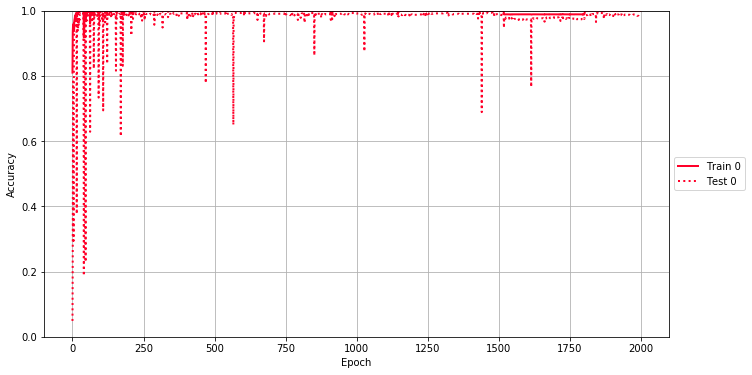

In [10]:
plot_acc(history)

In [11]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

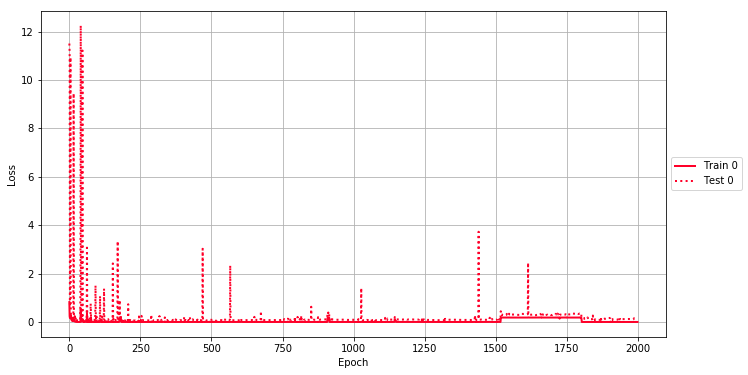

In [12]:
plot_loss(history)

Plotting the confusion matrix


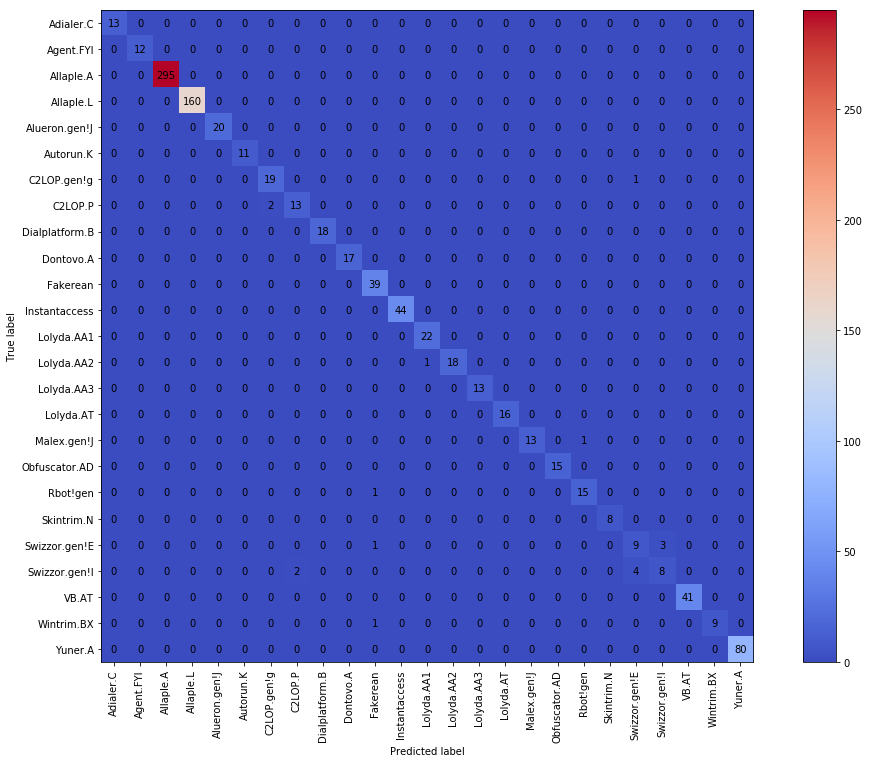

In [13]:
print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(18, 12)
plt.imshow(conf_mat,interpolation='nearest',cmap='coolwarm')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(int(conf_mat[row][col])),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


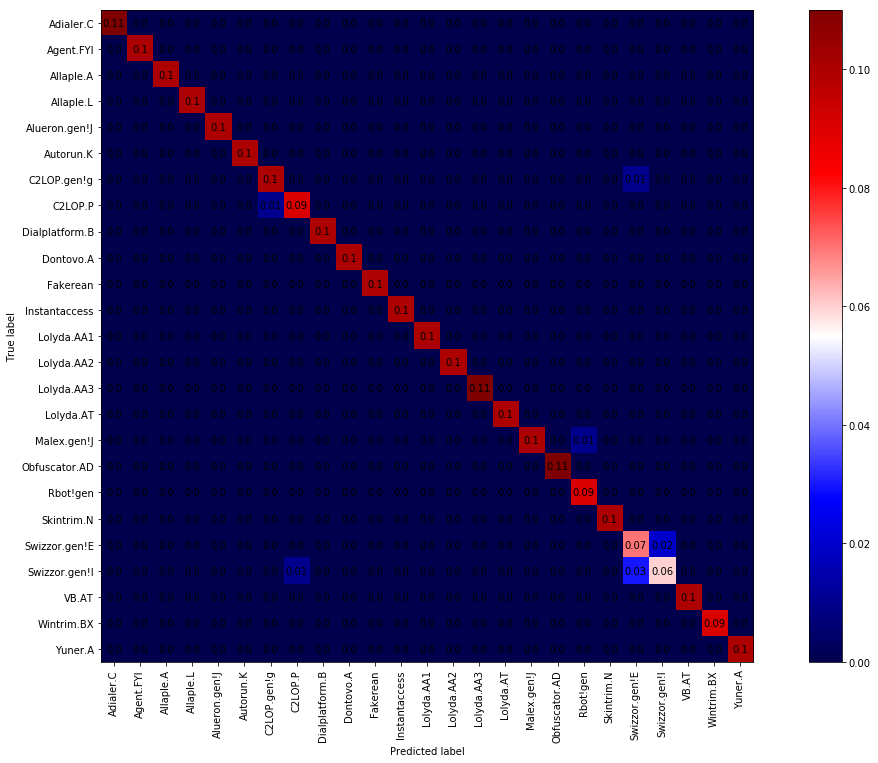

In [14]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(20, 12)
plt.imshow(conf_mat_norm,interpolation='nearest',cmap='seismic')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat_norm[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


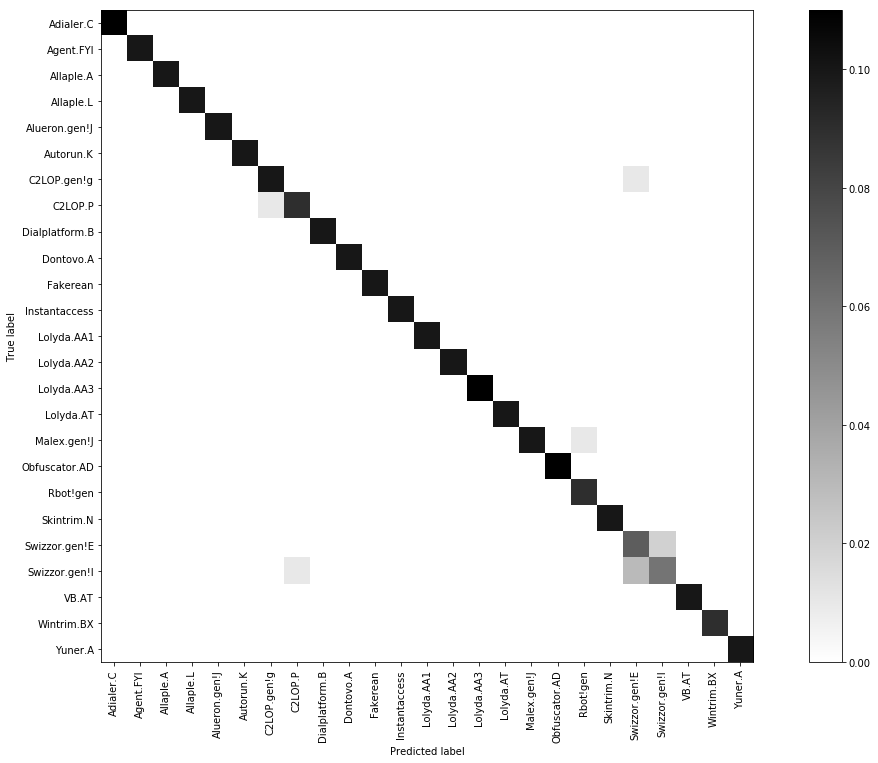

In [15]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(20, 12)
plt.imshow(conf_mat_norm,interpolation='nearest',cmap='binary')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

Plotting the confusion matrix normalized


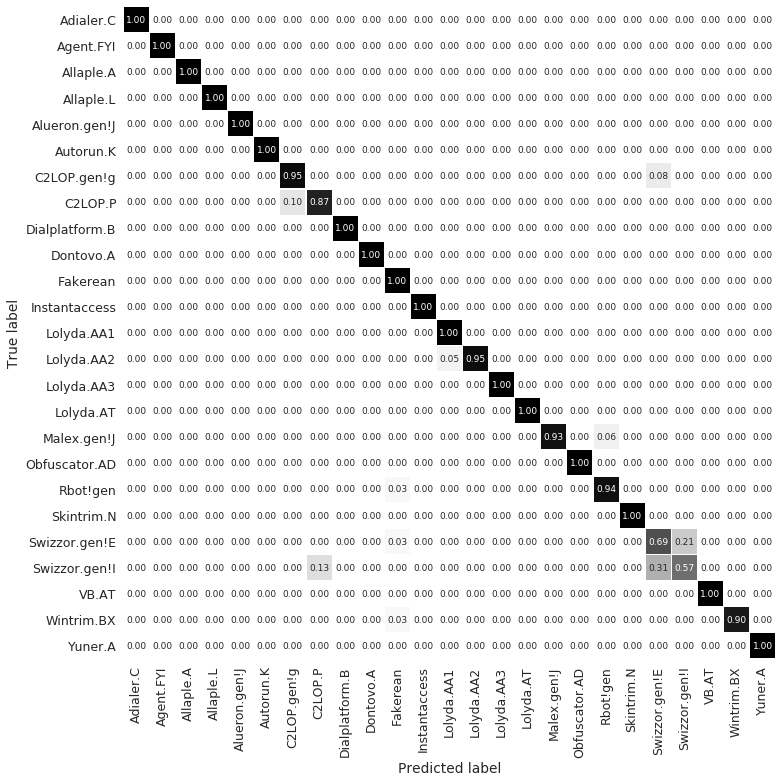

In [16]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 9}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()